# Tutorial <span style='color:red'>?</span>: Small Angle Neutron Scattering

Small Angle Neutron Scattering (SANS) is a powerful reciprocal space technique that can be used to investigate magnetic structures on mesoscopic length scales. In SANS the atomic structure generally has a minimal impact hence the sample can be approximated by a continuous magnetisation vector field \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\].

The differential scattering cross section $d\Sigma/d\Omega$ can be used as a function of the scattering vector ${\bf q}$ to predict the scattering patterns produced. The scattering can be calculated with the use of the magnetic interaction vector  ${\bf Q}$ \[[Mühlbauer 2019](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.91.015004)\] where

\begin{equation}
    {\bf Q} = \hat{\bf q} \times \left[ \hat{\bf q} \times \widetilde{\bf M} \right],
\end{equation}
where $\hat{\bf q}$ is the unit scatering vector and $\widetilde{\bf M}$ is the Fourier transform of the magnetisation.

The scattering vector is defined as 
\begin{equation}
    {\bf q} = {\bf k}_1 - {\bf k}_0
\end{equation}
where ${\bf k}_0$ and ${\bf k}_1$ are the incident and scattered wavevectors respectively.

## SANS Reference frame

There are common scattering geometries defined in SANS, namely with a magnetic field applied to the incoming neutron beam in either a perpendicular or and parallel geometry. 

**Perpendicular geometry**: the magnetic field is applied along the $z$ direction while the incoming neutron beam propagates along the $x$ direction.

**Parallel geometry**: both the magnetic field and the incoming neutron beam are along the $z$ direction.

When computing SANS, one has to be careful that the coordinate axes and applied magnetic field direction that are used for the micromagnetic simulation matches that of the desired SANS geometry. If this is not the case then rotations of the micromagnetic object should be performed so that coordinate axes are congruent with the desired scattering geometry. 

<img src="Figures/SANS.png" width="500" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-Dimentional magntic structure with periodic boundary conditions in the $xy$ plane.

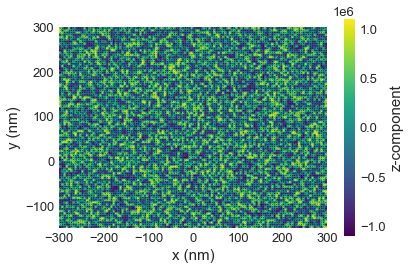

In [2]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

region = df.Region(p1=(-300e-9, -150e-9, 0), p2=(300e-9, 300e-9, 5e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xy')

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

Relax the system and plot its magnetisation.

In [3]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

Running OOMMF (DockerOOMMFRunner) [2021/07/30 15:30]... (132.7 s)


AttributeError: 'Mpl' object has no attribute 'plot'

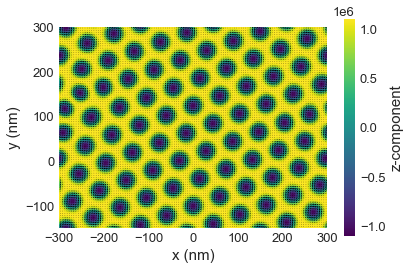

In [4]:
system.m.plane('z').mpl()

Now we have a magnetisation texture we can compute the SANS scattering cross sections.

## Computing SANS Cross-sections

We can use the `mag2exp` package to calculate the cross sections. First the geometry has to be chosen, then for this geometry the magnetic interaction vector  ${\bf Q}$ is calculated. From this the non-spin flip and spin flip cross sections can be calculated.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}

These then be combined inorder to get the half and unpolarised cross sections.

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

For example the unpolarised cross section for the parallel scattering geometry can be calculated.

In [5]:
import mag2exp

In [6]:
cross_section = mag2exp.sans.cross_section(system.m, method='unpol', geometry='parallel')

As the cross section is a `discretisedfield` object the built in plotting functions can be used to view them. The cross section is a complex quantity, hence to view it either the real or imaginary part or the norm has to be selected before plotting.

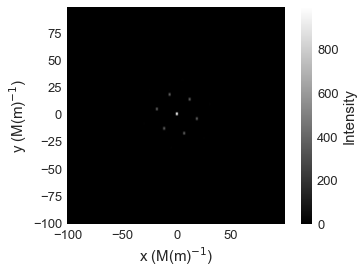

In [15]:
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

Due to the high intensity of some areas a linear colour map make some features more difficult to see. We can use `matplotlib.color` to change the colour bar to a logarithmic scale. This 
reveals the higher order low intensity diffraction peaks. 

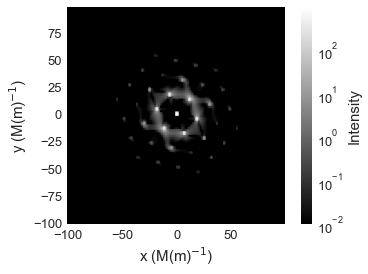

In [17]:
import matplotlib.colors as colors
cross_section.real.mpl.scalar(cmap='gray',
                              colorbar_label=r'Intensity', norm=colors.LogNorm(vmin=0.01,vmax=cross_section.real.array.max()))

It is also possible to just plot a selected region of the cross section by

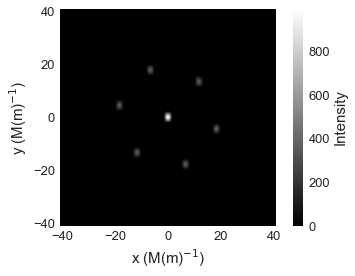

In [24]:
sans_region = df.Region(p1=(-40e6, -40e6, 0), p2=(40e6, 40e6, 0.5))
cross_section[sans_region].real.mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

For this in the parallel scattering geometry the spin-flip cross sections are

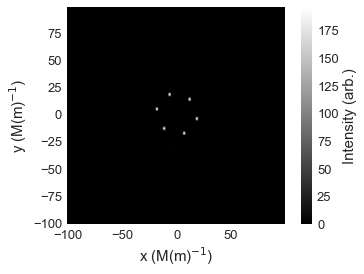

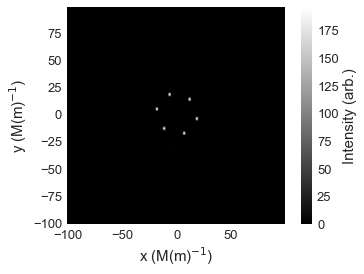

In [25]:
cross_section = mag2exp.sans.cross_section(system.m, method='pn', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section(system.m, method='np', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

and non-spin-flip cross sections are

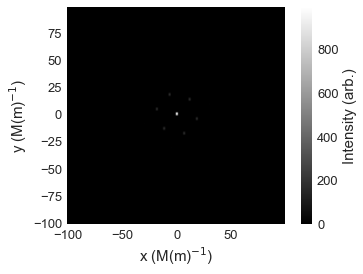

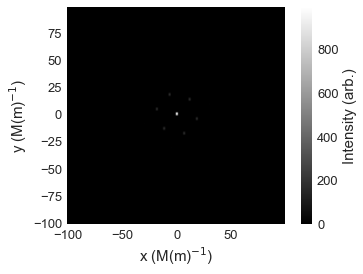

In [26]:
cross_section = mag2exp.sans.cross_section(system.m, method='pp', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')
cross_section = mag2exp.sans.cross_section(system.m, method='nn', geometry='parallel')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

We can also look at the perpediular geometry.

We can also look at the perpediular geometry. If we wish to look along the $z$ direction of the sample we will have to rotate the sample so the axes are congruent with the defitions we set i.e. rotate the samples $z$ axis to the $x$ axis as the beam is defined as traveling along the $x$ direction.

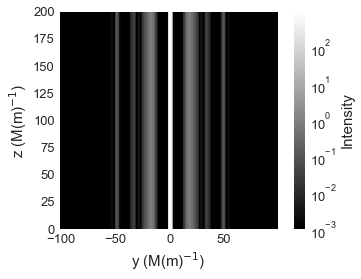

In [34]:
cross_section = mag2exp.sans.cross_section(system.m, method='unpol', geometry='perpendicular')
cross_section.real.mpl.scalar(cmap='gray', #interpolation='spline16', 
                              colorbar_label=r'Intensity', norm=colors.LogNorm(vmin=0.001,vmax=cross_section.real.array.max()))

It is possible to examine the chiral function as well

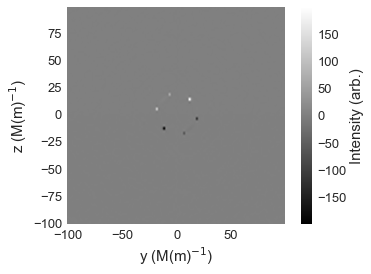

In [84]:
chiral = mag2exp.sans.chiral_function(system.m, geometry='perpendicular')
chiral.imag.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

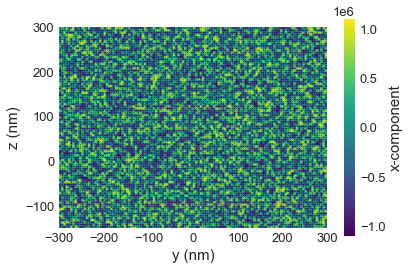

In [72]:
np.random.seed(1)

region = df.Region(p1=(0, -300e-9, -150e-9), p2=(5e-9, 300e-9, 300e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='yz')

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.Zeeman(H=(2e5, 0, 0)))

Ms = 1.1e6

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('x').mpl()

Running OOMMF (DockerOOMMFRunner) [2021/07/30 16:33]... (342.5 s)


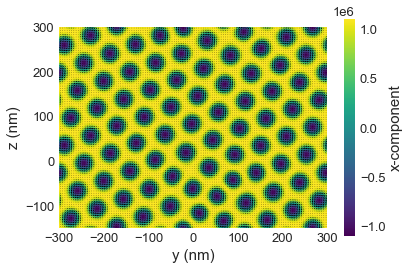

In [73]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('x').mpl()

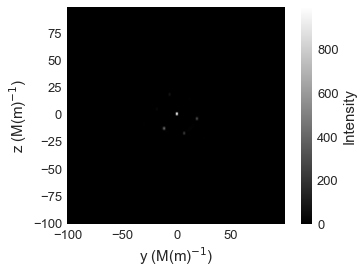

In [79]:
cross_section = mag2exp.sans.cross_section(system.m, method='np', geometry='perpendicular')
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

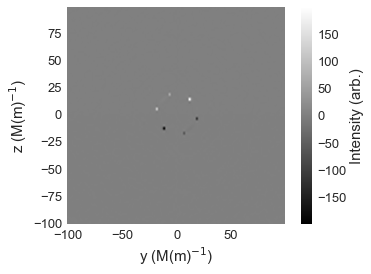

In [83]:
chiral = mag2exp.sans.chiral_function(system.m, geometry='perpendicular')
chiral.imag.mpl.scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')